<a href="https://colab.research.google.com/github/HumailShahzad/AlphabetConvertor/blob/main/M5Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Upload the sales data file (sales_train_validation.csv)
# from your local machine to the Colab environment.
# You can do this by clicking on the folder icon on the left sidebar,
# then clicking the upload icon.

In [3]:
# Step 2: Load the Sales Data
sales = pd.read_csv('/sales_train_validation.csv')

# Example selection: One product in one store
item_id = 'FOODS_3_090'
store_id = 'CA_1'

# Filter the sales data
df = sales[(sales['item_id'] == item_id) & (sales['store_id'] == store_id)]
df = df.iloc[:, 6:].T  # keep only d_1 to d_1941
df.columns = ['sales']
df.index = pd.date_range(start='2011-01-29', periods=len(df), end='2013-01-29' ).date

df.head()

,sales
2011-01-29,107
2011-01-29,182
2011-01-29,47
2011-01-30,47
2011-01-30,62


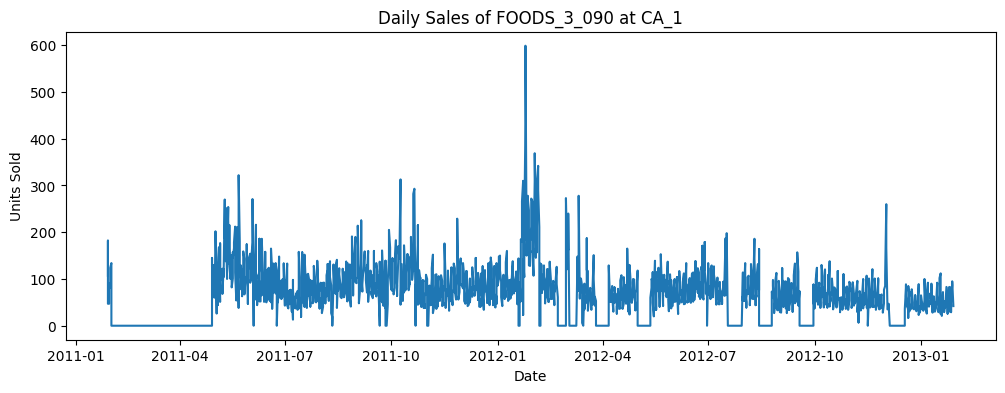

In [4]:
# Step 3: Visualize the Time Series
plt.figure(figsize=(12, 4))
plt.plot(df['sales'])
plt.title(f"Daily Sales of {item_id} at {store_id}")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()


In [5]:
# Step 4: Check for Stationarity using Augmented Dickey-Fuller Test
series = df['sales'].dropna()

adf_result = adfuller(df['sales'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")
# If p > 0.05, data is non-stationary

ADF Statistic: -4.052419145464711
p-value: 0.0011595812433892558
Critical Value (1%): -3.4338164946764294
Critical Value (5%): -2.863071261312085
Critical Value (10%): -2.5675851863579537


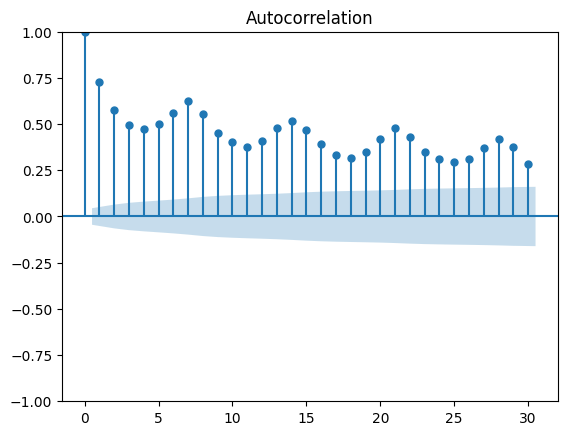

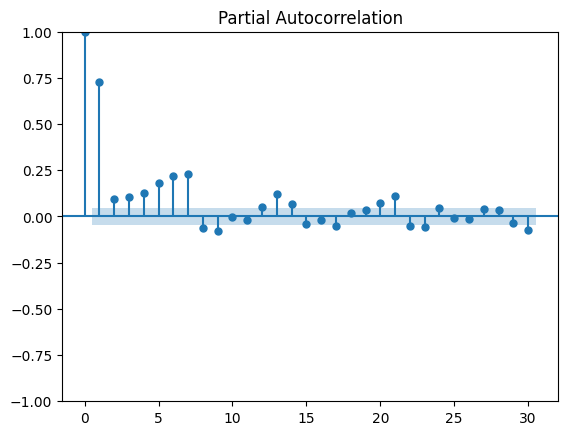

In [6]:
# Step 6: ACF & PACF to choose ARIMA(p,d,q)
plot_acf(df['sales'], lags=30)
plot_pacf(df['sales'], lags=30)
plt.show()


📌 Step 1: Determine d (differencing order)
Use ADF test.

Since p-value < 0.05, data is stationary.
no higher differencing required
d = 1

📌 Step 2: Choose p from PACF (Partial AutoCorrelation)
PACF shows the direct relationship of a time series with its own lagged values, removing effects of shorter lags.

From our PACF plot:

A big spike at lag 1, and smaller ones at lag 2–3, then near 0.

This suggests:
The series has short-term dependence on its own past value (lag 1 or 2).

After lag 2 or 3, the partial autocorrelations are small → no additional AR terms needed.
So we can try: p = 1 or 2



In [7]:
# Step 7: Fit ARIMA model
model = ARIMA(df, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1913
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -9659.586
Date:                Tue, 22 Jul 2025   AIC                          19327.173
Time:                        13:48:45   BIC                          19349.396
Sample:                             0   HQIC                         19335.351
                               - 1913                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2972      0.047      6.293      0.000       0.205       0.390
ma.L1         -0.7286      0.050    -14.596      0.000      -0.826      -0.631
ma.L2         -0.1387      0.037     -3.720      0.0

In [8]:
model = ARIMA(df, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1913
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9662.394
Date:                Tue, 22 Jul 2025   AIC                          19334.788
Time:                        13:48:47   BIC                          19362.568
Sample:                             0   HQIC                         19345.011
                               - 1913                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2740      0.147     -1.866      0.062      -0.562       0.014
ar.L2          0.2812      0.078      3.610      0.000       0.129       0.434
ma.L1         -0.1686      0.141     -1.194      0.2

In [9]:
model = ARIMA(df, order=(2,1,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1913
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -9576.726
Date:                Tue, 22 Jul 2025   AIC                          19165.452
Time:                        13:48:52   BIC                          19198.787
Sample:                             0   HQIC                         19177.719
                               - 1913                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2379      0.006    217.721      0.000       1.227       1.249
ar.L2         -0.9815      0.006   -168.959      0.000      -0.993      -0.970
ma.L1         -1.8266      0.011   -159.052      0.0

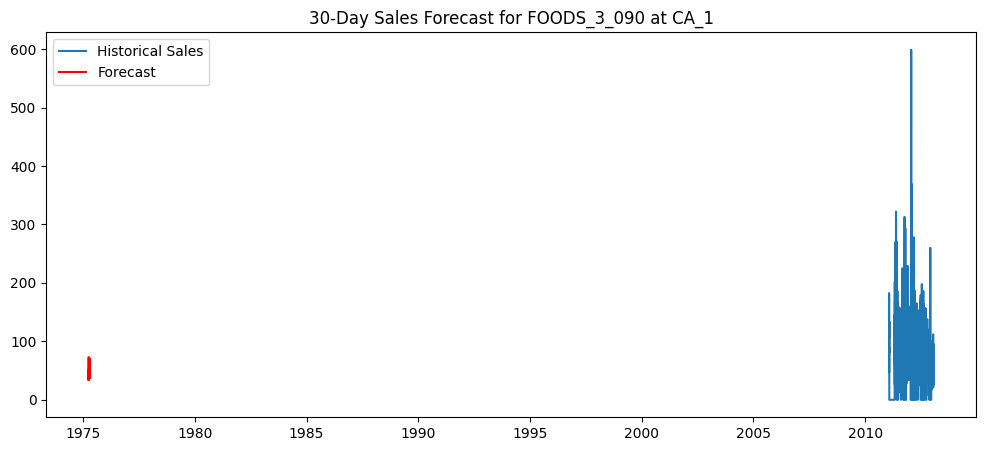

In [10]:
# Step 8: Forecast the next 30 days
forecast = model_fit.forecast(steps=30)
plt.figure(figsize=(12, 5))
plt.plot(df['sales'], label='Historical Sales')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title(f"30-Day Sales Forecast for {item_id} at {store_id}")
plt.show()


In [11]:
# Split the last 30 days for testing
train = df.iloc[:-30]
test = df.iloc[-30:]


In [12]:
model = ARIMA(train, order=(2, 1, 3))
model_fit = model.fit()


In [13]:
forecast = model_fit.forecast(steps=30)
forecast.index = test.index  # Align the forecast with test dates

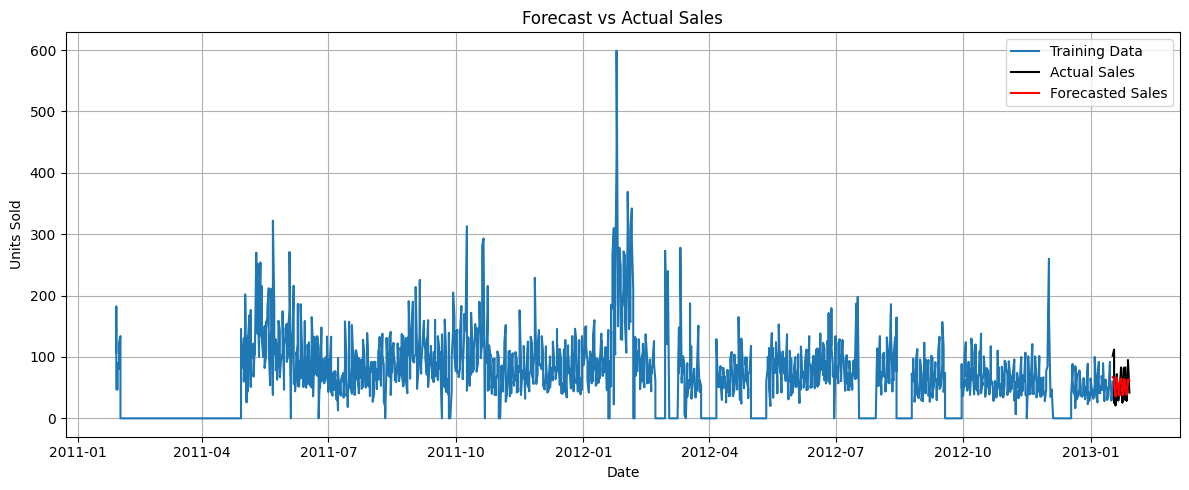

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train.index, train['sales'], label='Training Data')
plt.plot(test.index, test['sales'], label='Actual Sales', color='black')
plt.plot(forecast.index, forecast, label='Forecasted Sales', color='red')
plt.title("Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['sales'], forecast)
rmse = np.sqrt(mean_squared_error(test['sales'], forecast))
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 15.919598710320399, RMSE: 19.072916927430377


Applying Seasonal Arima to include seasonality

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [17]:
model = SARIMAX(
    df,
    order=(2, 1, 3),
    seasonal_order=(1, 1, 1, 30),  # weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                sales   No. Observations:                 1913
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 30)   Log Likelihood               -9336.627
Date:                              Tue, 22 Jul 2025   AIC                          18689.253
Time:                                      13:51:12   BIC                          18733.428
Sample:                                           0   HQIC                         18705.538
                                             - 1913                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1388      0.023     50.505      0.000       1.095       1.183
ar.L2         -0.87

In [18]:
model = SARIMAX(
    df,
    order=(2, 1, 3),
    seasonal_order=(1, 1, 1, 14),  # weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                sales   No. Observations:                 1913
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 14)   Log Likelihood               -9389.836
Date:                              Tue, 22 Jul 2025   AIC                          18795.673
Time:                                      13:51:41   BIC                          18839.985
Sample:                                           0   HQIC                         18811.994
                                             - 1913                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4436      0.171     -2.587      0.010      -0.780      -0.108
ar.L2          0.35

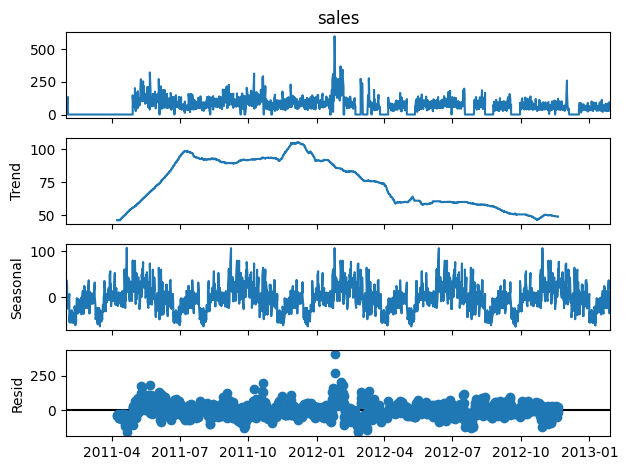

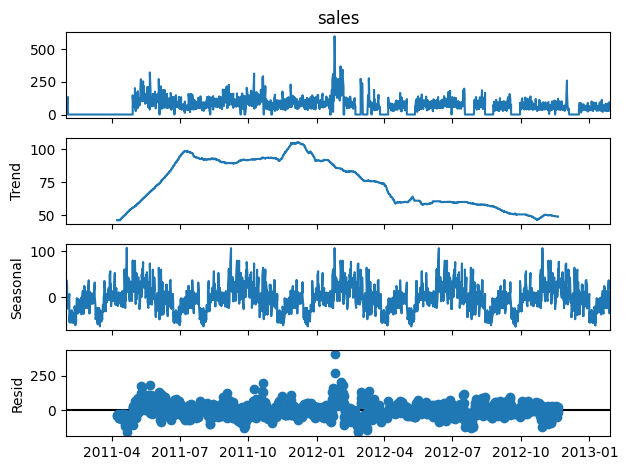

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(df['sales'], model='additive', period=365).plot()


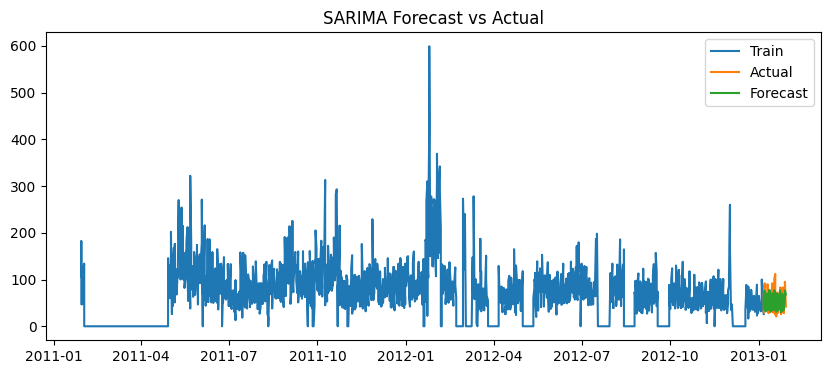

In [20]:
train = df.iloc[:-60]  # last 60 days = test
test = df.iloc[-60:]

model = SARIMAX(train, order=(2,1,3), seasonal_order=(0,1,1,14))
results = model.fit()
forecast = results.forecast(steps=60)

# Plot
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.show()


In [21]:
mae = mean_absolute_error(test['sales'], forecast)
rmse = np.sqrt(mean_squared_error(test['sales'], forecast))
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 11.785661682779768, RMSE: 15.215622368895433


Top 10 Products

In [22]:
# Load data
df_sale = pd.read_csv("/sales_train_validation.csv")
df_sales=df_sale[df_sale['cat_id']=='HOBBIES']
# Sum across all days (d_1 to d_1913)
product_sales = df_sales.drop(columns=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']).sum(axis=1)
df_sales['total_sales'] = product_sales

top_10_products = df_sales[['item_id', 'total_sales']].sort_values(by='total_sales', ascending=False)
top_10_products.head(10)


,item_id,total_sales
6324,HOBBIES_1_234,29742
339,HOBBIES_1_348,22744
362,HOBBIES_1_371,22595
6344,HOBBIES_1_254,20996
6460,HOBBIES_1_371,19812
6437,HOBBIES_1_348,19407
260,HOBBIES_1_268,18904
6430,HOBBIES_1_341,17844
6112,HOBBIES_1_015,17630
6358,HOBBIES_1_268,16973


Reordered products

In [23]:
# Melt to long format
sales_melted = df_sales.melt(
    id_vars=['item_id'], var_name='d', value_name='sales'
)

# Merge with calendar to get dates
calendar = pd.read_csv("/calendar.csv")
sales_merged = sales_melted.merge(calendar[['d', 'date']], on='d', how='left')
sales_merged['date'] = pd.to_datetime(sales_merged['date'])

# Group by item_id and date
sales_merged['is_reorder'] = sales_merged.duplicated(subset=['item_id'], keep='first').astype(int)

# Daily
daily_reorders = sales_merged.groupby('date')['is_reorder'].sum()
sales_merged = sales_merged[sales_merged['date'].notna()]  # Drop rows with missing dates

# Weekly
sales_merged['week'] = sales_merged['date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_reorders = sales_merged.groupby('week')['is_reorder'].sum()

# Monthly
sales_merged['month'] = sales_merged['date'].dt.to_period('M').apply(lambda r: r.start_time)
monthly_reorders = sales_merged.groupby('month')['is_reorder'].sum()


Top Departments/Products of Reordered Items

In [ ]:
# Need to merge original sales to get dept info
sales_merged = sales_merged.merge(df_sales[['item_id', 'dept_id']], on='item_id', how='left')

top_depts_reordered = sales_merged[sales_merged['is_reorder']==1] \
    .groupby('dept_id')['item_id'].count() \
    .sort_values(ascending=False).head(10)


Orders and reorders by day of week

In [ ]:
calendar['weekday'] = pd.to_datetime(calendar['date']).dt.day_name()

sales_by_day = sales_melted.merge(calendar[['d', 'weekday']], on='d')
sales_by_day['is_reorder'] = sales_by_day.duplicated(subset=['item_id'], keep='first').astype(int)

orders_by_day = sales_by_day.groupby('weekday')['sales'].sum()
reorders_by_day = sales_by_day.groupby('weekday')['is_reorder'].sum()

# Reorder days for plotting
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
orders_by_day = orders_by_day.reindex(days_order)
reorders_by_day = reorders_by_day.reindex(days_order)


General trends of products

In [ ]:
# Overall trend of sales across all products
total_sales_per_day = df_sales.drop(columns=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']).sum()

# Add dates
total_sales_df = pd.DataFrame({'d': total_sales_per_day.index, 'total_sales': total_sales_per_day.values})
total_sales_df = total_sales_df.merge(calendar[['d', 'date']], on='d')
total_sales_df['date'] = pd.to_datetime(total_sales_df['date'])

# Plot
total_sales_df.set_index('date')['total_sales'].plot(title='Overall Sales Trend')


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(total_sales_df.set_index('date')['total_sales'], model='additive', period=7)
decomposed.plot()
